## Imports


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

Reading the CSV


In [2]:
reviews_df = pd.read_csv("Reviews.csv")
print(reviews_df.shape)
reviews_df.head()

(3999, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,50057,B000ER5DFQ,A1ESDLEDR9Y0JX,A. Spencer,1,2,1,1310256000,the garbanzo beans in it give horrible gas,To be fair only one of my twins got gas from t...
1,366917,B001AIQP8M,A324KM3YY1DWQG,danitrice,0,0,5,1251072000,Yummy Lil' Treasures!!,Just recieved our first order of these (they d...
2,214380,B001E5E1XW,A3QCWO53N69HW3,"M. A. Vaughan ""-_-GOBNOGO-_-""",2,2,5,1276473600,Great Chai,This is a fantastic Chai Masala. I am very pic...
3,178476,B000TIZP5I,AYZ5NG9705AG1,Consumer,0,0,5,1341360000,Celtic Salt worth extra price,Flavorful and has added nutrition! You use le...
4,542504,B000E18CVE,A2LMWCJUF5HZ4Z,"Miki Lam ""mikilam""",8,11,3,1222732800,mixed feelings,I thought this soup tasted good. I liked the t...


will be using the Text and Score columns


In [3]:
reviews_df = reviews_df[
    ["Text", "Score"]
].dropna()  # choosing text, score column and dropping missing values
reviews_df.head()

,Text,Score
0,To be fair only one of my twins got gas from t...,1
1,Just recieved our first order of these (they d...,5
2,This is a fantastic Chai Masala. I am very pic...,5
3,Flavorful and has added nutrition! You use le...,5
4,I thought this soup tasted good. I liked the t...,3


### Looking at the distribution of review scores


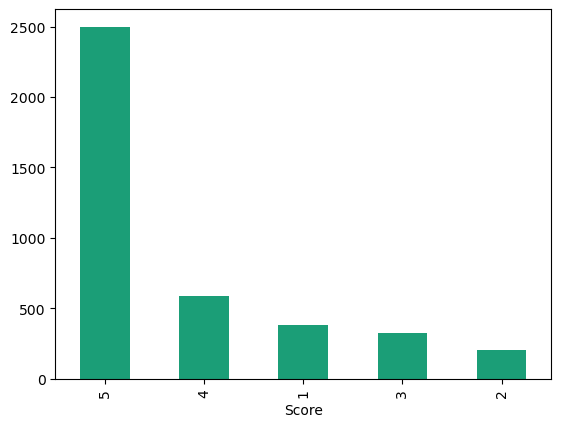

In [4]:
ax = reviews_df.Score.value_counts().plot(kind="bar", colormap="Dark2")
plt.show()

consider ratings 1,2,3 as negative review and 4, 5 ast positive review


In [5]:
reviews_df.Score[reviews_df.Score <= 3] = 0  # Negative
reviews_df.Score[reviews_df.Score >= 4] = 1  # Positive

C:\Users\mbele\AppData\Local\Temp\ipykernel_3696\2546510048.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  reviews_df.Score[reviews_df.Score <= 3] = 0  # Negative
C:\Users\mbele\AppData\Local\Temp\ipykernel_3696\2546510048.py:1: Setting

plotting distribution ratings again


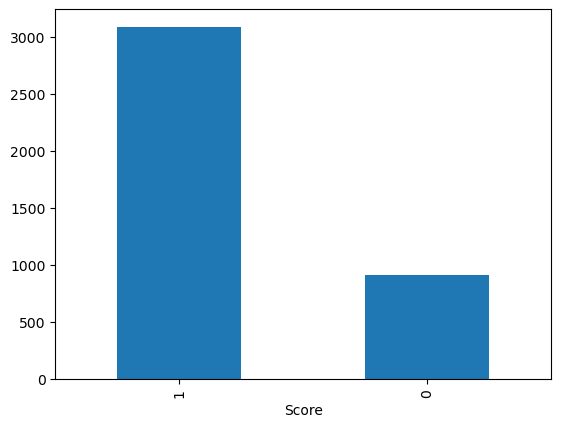

,Text,Score
0,To be fair only one of my twins got gas from t...,0
1,Just recieved our first order of these (they d...,1
2,This is a fantastic Chai Masala. I am very pic...,1
3,Flavorful and has added nutrition! You use le...,1
4,I thought this soup tasted good. I liked the t...,0


In [6]:
ax = reviews_df.Score.value_counts().plot(kind="bar")
plt.show()
reviews_df.head()

## Training the classifier


In [7]:
import spacy
import random
from spacy.training import Example
from spacy.pipeline.textcat_multilabel import DEFAULT_MULTI_TEXTCAT_MODEL

#### creating the pipeline


In [8]:
nlp = spacy.load("en_core_web_lg")
config = {"threshold": 0.5, "model": DEFAULT_MULTI_TEXTCAT_MODEL}

textcat = nlp.add_pipe("textcat_multilabel", config=config)

### converting training sentences and ratings into a spaCy usable format.


In [9]:
train_examples = []
for index, row in reviews_df.iterrows():
    text = row["Text"]
    rating = row["Score"]
    label = {"POS": True, "NEG": False} if rating == 1 else {"NEG": True, "POS": False}
    train_examples.append(Example.from_dict(nlp.make_doc(text), {"cats": label}))

In [10]:
textcat.add_label("POS")
textcat.add_label("NEG")
textcat.initialize(lambda: train_examples, nlp=nlp)

### Defining training loop


In [11]:
epochs = 2
with nlp.select_pipes(enable="textcat_multilabel"):
    optimizer = nlp.resume_training()
    losses = {}
    for i in range(epochs):
        random.shuffle(train_examples)
        for example in train_examples:
            nlp.update([example], sgd=optimizer, losses=losses)
        print(losses)

{'textcat_multilabel': 718.2989409504437}
{'textcat_multilabel': 1138.1155659174772}


### Testing the model


In [20]:
doc2 = nlp("This is the best food I ever ate")
doc2.cats

print(f"Positive: {doc2.cats['POS']} \nNegative: {doc2.cats['NEG']}")

Positive: 0.9424263834953308 
Negative: 0.048529017716646194


In [31]:
doc3 = nlp("This food is so bad")
doc3.cats


print(f"Positive: {doc3.cats['POS']} \nNegative: {doc3.cats['NEG']}")

Positive: 0.5733187198638916 
Negative: 0.4046725630760193
